In [1]:
from distutils.archive_util import make_archive
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from os import listdir
from os.path import isfile, join
import cv2

In [2]:


def skin_color_filter(im):
    # vhod: barvna slika
    # izhod: odziv filtra za barvo kože
    r, g, b = [im[:, :, c] for c in range(3)] 
    mask = reduce(np.logical_and, (r>95, g>40, b>20, (reduce(np.maximum, (r,g,b)) - reduce(np.minimum, (r,g,b))) > 15, np.abs(r-g) > 15, r > g, r > b))
    return mask.astype(np.uint8)

def fill(mask):
    im_floodfill = mask.copy()

    h, w = mask.shape[:2]
    new_mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(im_floodfill, new_mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = mask | im_floodfill_inv
    return im_out

def dilate(mask):
    # vhod: maska
    # izhod: maska, očiščena z dilatacijo s 5*5 kvadratnim strukturnim elementom
    return cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=1)

def clean_skin_mask(mask):
    # kombinacija polnjenja lukenj in dilatacije
    return dilate(fill(mask))//255

def rgb2gray(im):
    # vhod: barvna slika
    # izhod: sivinska slika, dobljena s povprečenjem kanalov
    return np.mean(im, axis=2)

def smooth_gray_image(im):
    # vhod: sivinska slika
    # izhod: sivinska slika, zglajena s 7*7 Gaussovim jedrom s sigma=2
    return cv2.GaussianBlur(im, (7,7), 2)

def gradient_approximation(im):
    # vhod: zglajena siva slika
    # izhod: približek amplitude gradientov
    sobel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    sobel_y = np.transpose(sobel_x)

    edges_x = cv2.filter2D(im, -1, kernel=sobel_x)
    edges_y = cv2.filter2D(im, -1 ,kernel=sobel_y)

    return np.sqrt(np.square(edges_x) + np.square(edges_y)).astype(np.uint8)

def mask_edges(edges, mask):
    # vhoda: amplituda gradientov, maska barve kože
    # izhod: slika amplitude gradientov, maskirana na področja ki ustrezajo
    #        odzivu filtra barve kože
    return (edges * mask)

def threshold_edges(edges):
    # vhod: maskirana slika amplitude gradientov
    # izhod: binarna slika, rezultat upragovljanja slike amplitude gradientov
    #        s pragom 40
    return (edges > 40).astype(np.uint8)

def fit_ellipse(bin_edges):
    # vhod: binarna slika robov, maskiranih s področjem kože
    # izhod: parametri elipse
    points = []
    for x in range(bin_edges.shape[1]):
        for y in range(bin_edges.shape[0]):
            if bin_edges[y, x] > 0:
                points.append((x, y))
    
    points = np.array(points).astype("float32")
    ell = cv2.fitEllipse(points)
    return ell

def draw_ellipse(im, ell):
    # vhod: barvna slika in parametri elipse
    # izhod: slika z vrisano elipso
    centre, axes, angle = ell
    centre = (int(round(centre[0])), int(round(centre[1])))
    axes = (int(round(axes[0]/2)), int(round(axes[1]/2)))
    angle = int(round(angle))
    #print(centre, axes, angle)

    im_in = im.astype("float64")
    face_det = cv2.ellipse(im_in, center=centre, axes=axes, angle=angle, 
                           startAngle=0.0, endAngle=360.0, color=(255, 0, 0),
                           thickness=3)
    return face_det.round().astype("uint8")



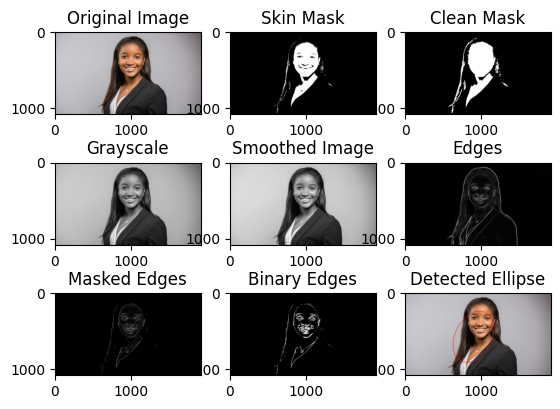

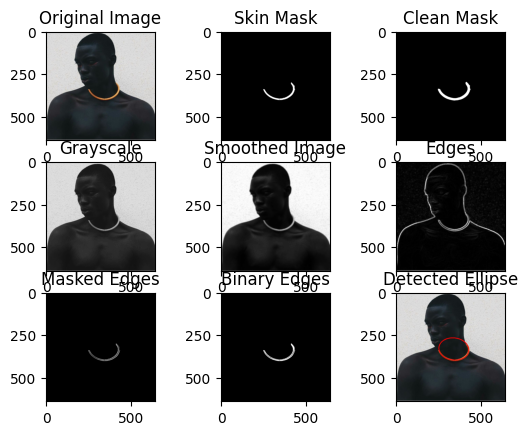

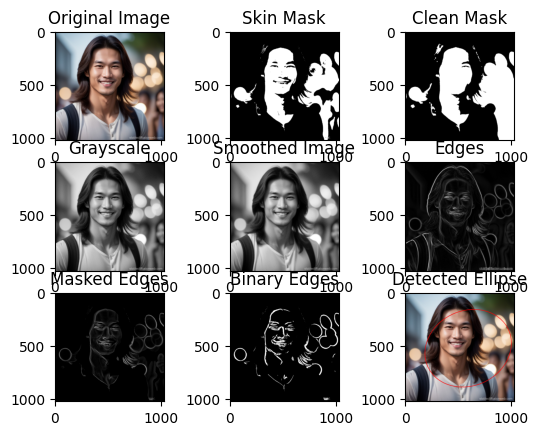

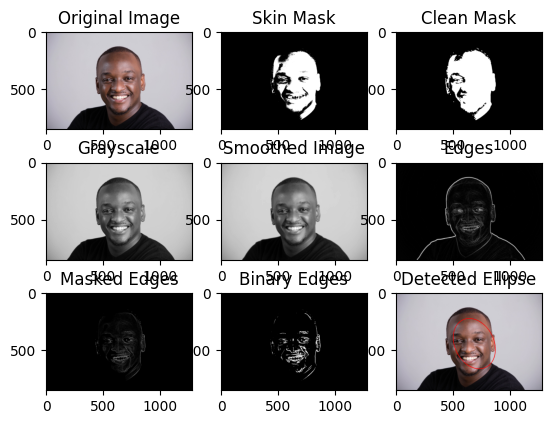

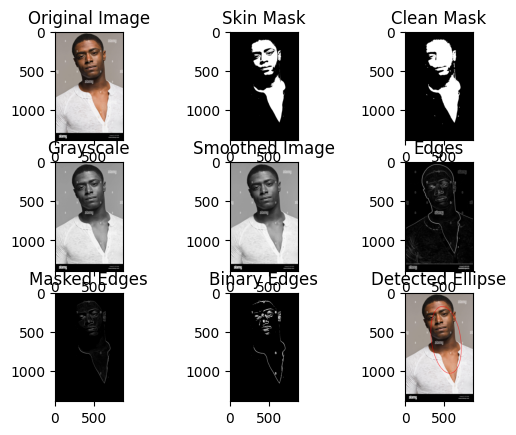

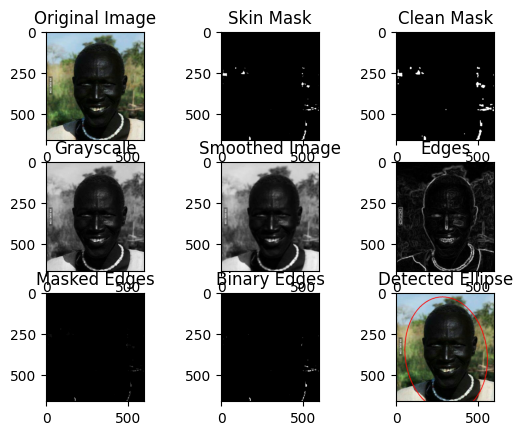

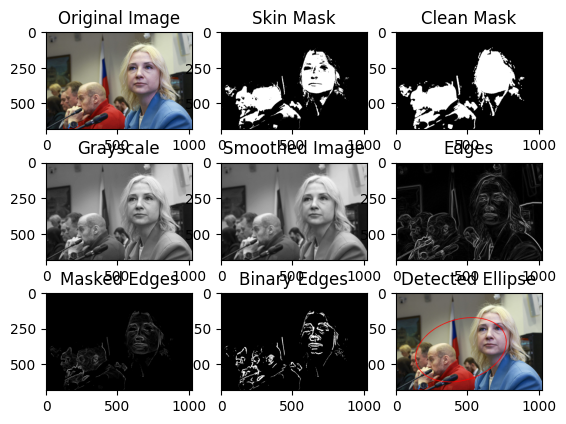

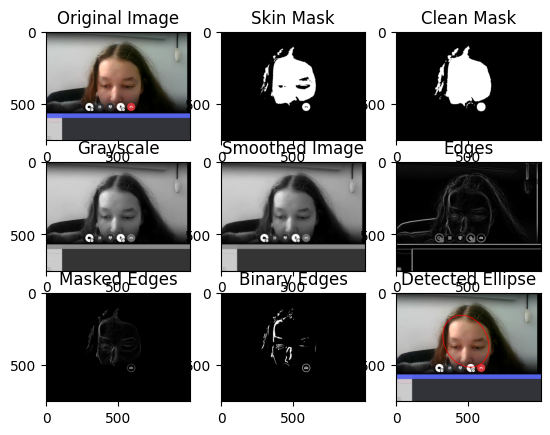

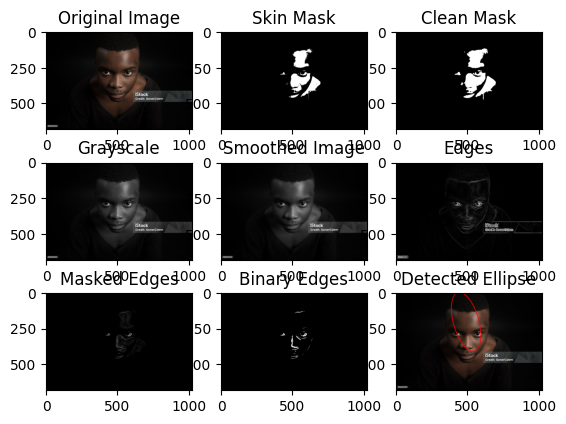

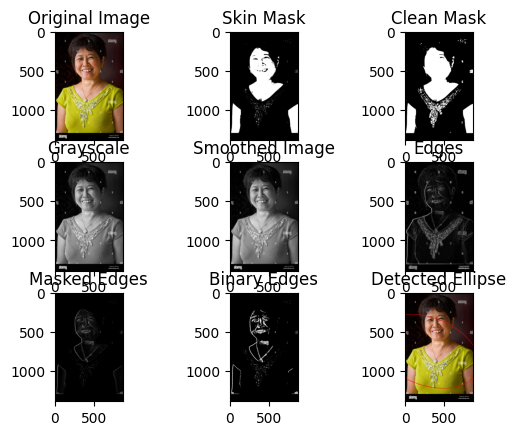

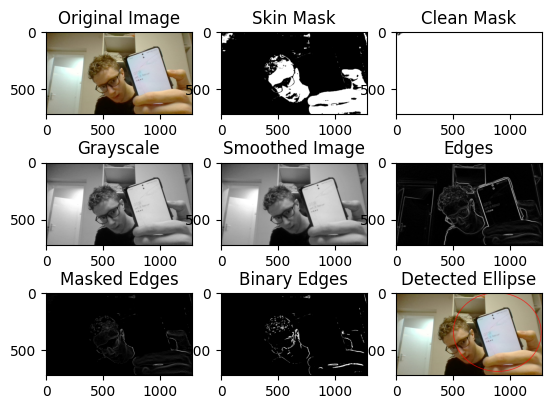

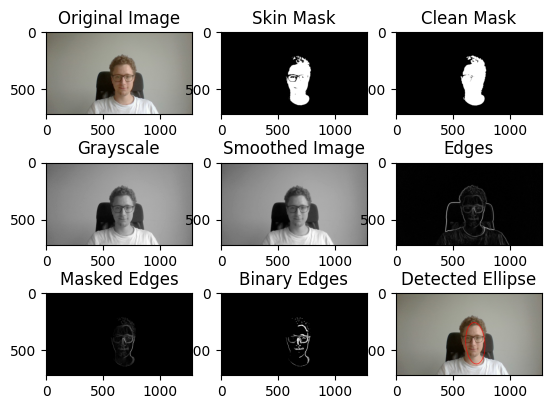

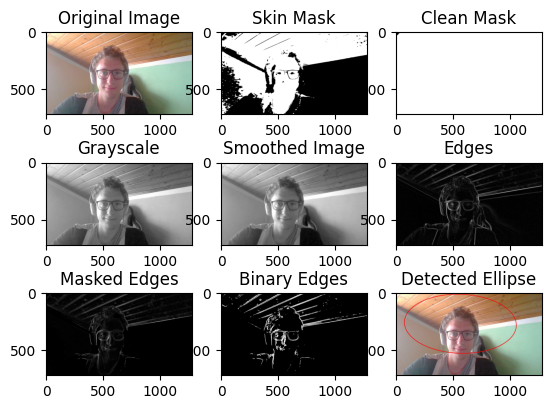

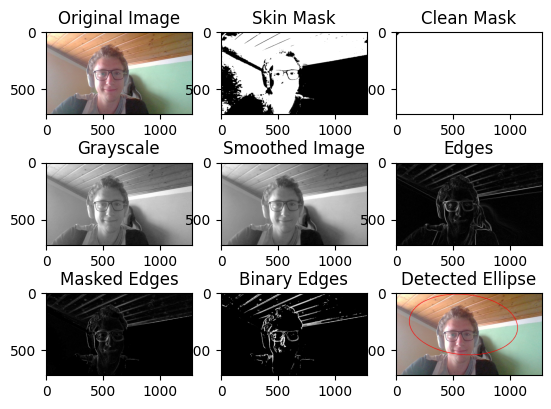

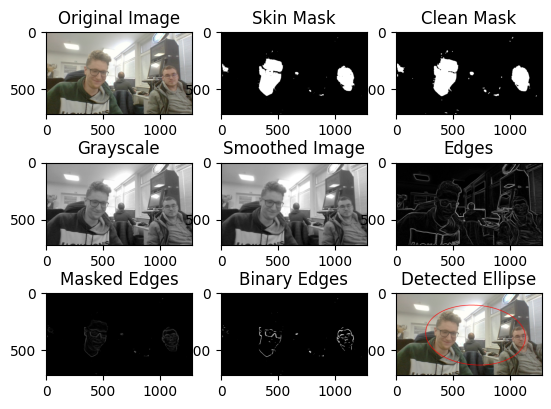

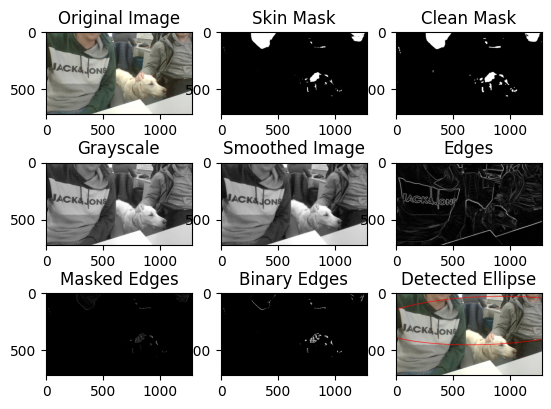

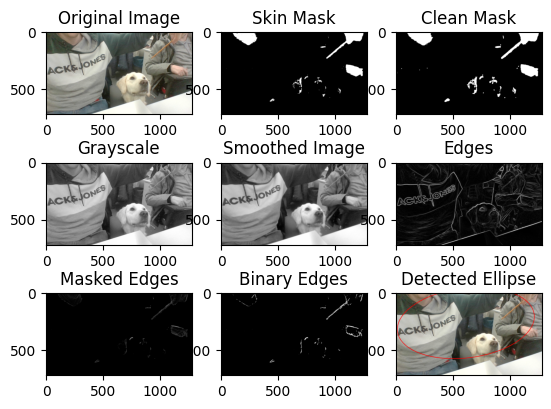

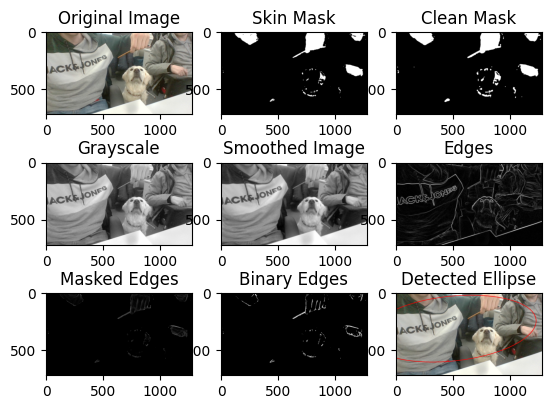

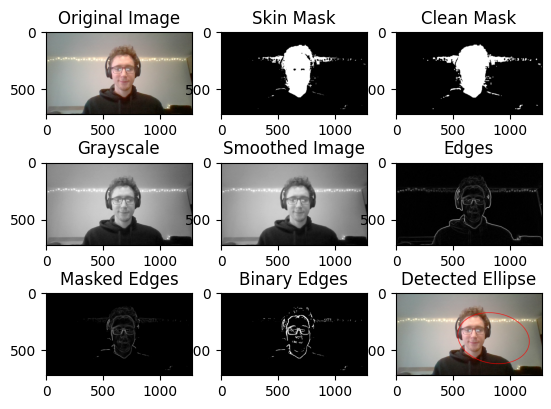

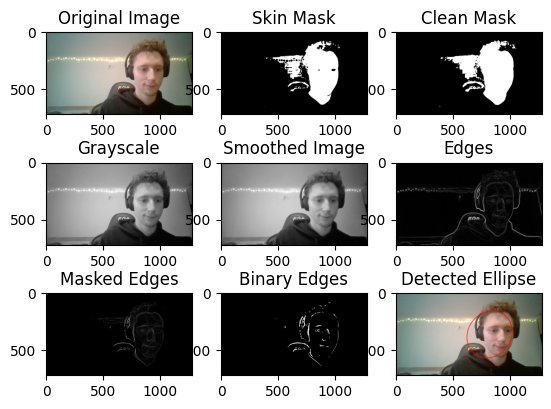

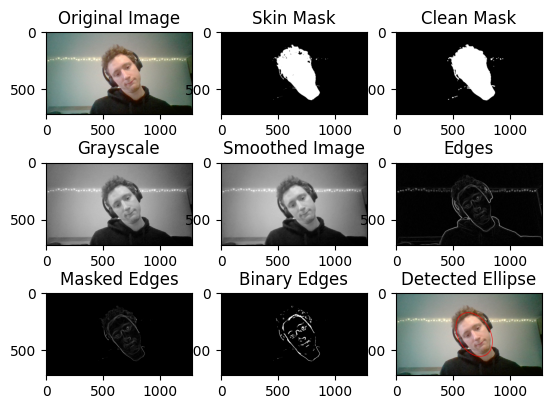

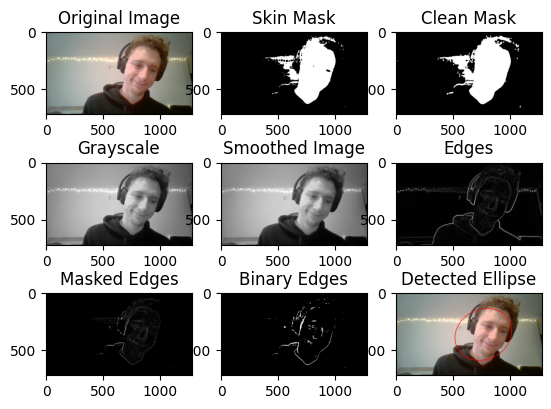

''

In [3]:



slike = [join('slike', f) for f in listdir('slike') if isfile(join('slike', f))]
    
for slika in slike:
    # sestavi implementirane funkcije v celoten algoritem za zaznavanje obrazov
    plt.figure()

    image = cv2.imread(slika)[:,:,::-1]
    mask = skin_color_filter(image)
    clean_mask = clean_skin_mask(mask)
    gray = rgb2gray(image)
    smooth = smooth_gray_image(gray)
    edges = gradient_approximation(smooth)
    masked_edges = mask_edges(edges, mask)
    binary_edges = threshold_edges(masked_edges)
    detected = draw_ellipse(image, fit_ellipse(binary_edges))

    detailed = True
    if detailed:
        plt.subplot(3,3,1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.subplot(3,3,2)
        plt.imshow(mask, 'gray')
        plt.title("Skin Mask")
        plt.subplot(3,3,3)
        plt.imshow(clean_mask, 'gray')
        plt.title("Clean Mask")
        plt.subplot(3,3,4)
        plt.imshow(gray, 'gray')
        plt.title("Grayscale")
        plt.subplot(3,3,5)
        plt.imshow(smooth, 'gray')
        plt.title("Smoothed Image")
        plt.subplot(3,3,6)
        plt.imshow(edges, 'gray')
        plt.title("Edges")
        plt.subplot(3,3,7)
        plt.imshow(masked_edges, 'gray')
        plt.title("Masked Edges")
        plt.subplot(3,3,8)
        plt.imshow(binary_edges, 'gray')
        plt.title("Binary Edges")
        plt.subplot(3,3,9)
        plt.imshow(detected)
        plt.title("Detected Ellipse")

    plt.show(block=False)
    plt.pause(0.001)

input("Press ENTER to continue...")